In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
%matplotlib inline 
#Importing our defined functions to clean
from clean_data_functions import *
from scipy.stats import mode

import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None) 
sns.set_theme(style ="whitegrid")

%matplotlib inline

In [203]:
open_meteo_df_h = pd.read_csv("DATA/open-meteo-hourly-mexico-city_2024-02-01_2024-03-06.csv", skiprows=3)

open_meteo_df_f = pd.read_csv("DATA/open-meteo-hourly-mexico-city_forecast 2024-03-06_2024-03-20.csv", skiprows=3)


In [204]:
open_meteo_df_h.dropna(inplace=True)

In [205]:
weather_df = pd.concat([open_meteo_df_h, open_meteo_df_f], ignore_index=True)

In [206]:
weather_df.duplicated(subset=['time']).sum()

24

In [207]:
weather_noscale= weather_df.drop_duplicates(subset=['time'])

In [208]:
weather_df.isna().sum()

time                         0
temperature_2m (°C)          0
relative_humidity_2m (%)     0
apparent_temperature (°C)    0
rain (mm)                    0
cloud_cover (%)              0
wind_speed_10m (km/h)        0
is_day ()                    0
dtype: int64

In [209]:
#        'cloud_cover_(%)': 'cloud_cover_perc', 

In [210]:
def wrangle_open_meteo(open_meteo_df):
    
    weather_columns = {
        'time': 'hour', 
        'temperature_2m_(°c)': 'temperature_C', 
        'relative_humidity_2m_(%)': 'rel_humidity_perc',
        'apparent_temperature_(°c)': 'feels_like_temp_C', 
        'rain_(mm)': 'rain_mm',

        'wind_speed_10m_(km/h)': 'wind_speed_kmh',
        'is_day_()':'is_day'
    }
    open_meteo_df.drop(columns=['cloud_cover (%)'], axis=1, inplace= True) 
    open_meteo_df.columns = [name.strip().replace(" ", "_").lower() for name in open_meteo_df.columns]
    open_meteo_df.rename(columns=weather_columns, inplace=True)
    
    
    # add is_business_day column 

    # Map the hourly_aggregated to a new column indicating business day [1] or weekend/holiday [0]

    # Public holidays in Mexico City:

    public_holidays = [ # month and day
        '01-01', # new year's day
        '02-05', # consistution day
        '03-21', # Benito Juárez's Birthday
        '05-01', # Labour day
        '09-16', # Independence day
        '11-20', # Revolution day
        '12-25', # Christmas
    ]

    # convert public_holidays to datetime format
    public_holidays_dt = [datetime.strptime(holiday, '%m-%d') for holiday in public_holidays]
    open_meteo_df['is_business_day'] = pd.to_datetime(open_meteo_df['hour']).apply(
        lambda x: 1 if (x.month, x.day) not in [(holiday.month, holiday.day) for holiday in public_holidays_dt] and (x.weekday() < 5) else 0
        )
    
    # reformat the hour column to match our aggregated ecobici df and set as index
    open_meteo_df['hour'] = pd.to_datetime(open_meteo_df['hour'], format='%Y-%m-%dT%H:%M')
    open_meteo_df.set_index('hour', inplace=True)

    

    return open_meteo_df



In [211]:
import pickle

# Load the saved model from the file
with open('sarimax_model_9.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
    
# Load the saved scalers and transformers
with open('scaler_9.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)

In [212]:
loaded_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                           rental_counts   No. Observations:                 9504
Model:             SARIMAX(2, 0, 1)x(0, 1, [1, 2], 24)   Log Likelihood              -23951.982
Date:                                 Mon, 11 Mar 2024   AIC                          47929.965
Time:                                         15:20:24   BIC                          48023.005
Sample:                                     01-01-2023   HQIC                         47961.542
                                          - 01-31-2024                                         
Covariance Type:                                   opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
is_business_day       2.4457      0.082     29.954      0.000       2.286       2.606
temperature_C         0.1623      0.107      1.521      0.128      -0.047       0.371
rel_humidity_perc     0.0023      0.007      0.357      0.721      -0.011       0.015
feels_like_temp_C    -0.0914      0.085     -1.072      0.284      -0.259       0.076
rain_mm              -0.0276      0.094     -0.293      0.769      -0.212       0.157
wind_speed_kmh       -0.0122      0.017     -0.725      0.468      -0.045       0.021
is_day               -0.6436      0.689     -0.934      0.351      -1.995       0.708
ar.L1                 0.0177      0.160      0.110      0.912      -0.296       0.331
ar.L2                 0.0617      0.018      3.490      0.000       0.027       0.096
ma.L1                 0.0768      0.160      0.479      0.632      -0.237       0.391
ma.S.L24             -0.7173      0.008    -92.357      0.000      -0.733      -0.702
ma.S.L48             -0.1812      0.008    -22.417      0.000      -0.197      -0.165
sigma2                8.8076      0.092     95.841      0.000       8.628       8.988
===================================================================================
Ljung-Box (L1) (Q):                  27.56   Jarque-Bera (JB):              2352.63
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                             0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [213]:
exogenous = wrangle_open_meteo(weather_noscale)

In [214]:
exogenous.columns

Index(['temperature_C', 'rel_humidity_perc', 'feels_like_temp_C', 'rain_mm',
       'wind_speed_kmh', 'is_day', 'is_business_day'],
      dtype='object')

In [215]:
column_names = ['temperature_C',
       'rel_humidity_perc', 'feels_like_temp_C', 'rain_mm',
       'wind_speed_kmh', 'is_day', 'is_business_day']

exogenous = pd.DataFrame(exogenous, columns=column_names)
exogenous = exogenous[['is_business_day', 'temperature_C', 'rel_humidity_perc',
                                   'feels_like_temp_C', 'rain_mm', 'wind_speed_kmh', 'is_day']]

In [216]:
exogenous

,is_business_day,temperature_C,rel_humidity_perc,feels_like_temp_C,rain_mm,wind_speed_kmh,is_day
hour,,,,,,,
2024-02-01 00:00:00,1,21.3,21.0,18.4,0.0,3.3,1
2024-02-01 01:00:00,1,19.5,26.0,15.4,0.0,13.0,0
2024-02-01 02:00:00,1,18.6,29.0,16.2,0.0,2.5,0
2024-02-01 03:00:00,1,17.0,40.0,13.6,0.0,12.3,0
2024-02-01 04:00:00,1,14.8,53.0,12.9,0.0,5.0,0
...,...,...,...,...,...,...,...
2024-03-18 19:00:00,1,18.8,31.0,19.6,0.0,3.3,1
2024-03-18 20:00:00,1,20.3,26.0,20.5,0.0,4.2,1
2024-03-18 21:00:00,1,20.4,27.0,19.2,0.0,6.6,1


In [217]:
# index = pd.date_range(start='2024-02-01 00:00:00', end='2024-03-18 23:00:00', freq='H')

# exogenous['date']= index


In [218]:
# exogenous.set_index('date', inplace=True)

In [219]:
exogenous_scaled = loaded_scaler.transform(exogenous)
pd.DataFrame(exogenous_scaled)

,0,1,2,3,4,5,6
0,1.0,0.593548,0.185567,0.572755,0.000000,0.085714,1.0
1,1.0,0.535484,0.237113,0.479876,0.000000,0.337662,0.0
2,1.0,0.506452,0.268041,0.504644,0.000000,0.064935,0.0
3,1.0,0.454839,0.381443,0.424149,0.000000,0.319481,0.0
4,1.0,0.383871,0.515464,0.402477,0.000000,0.129870,0.0
...,...,...,...,...,...,...,...
1123,1.0,0.512903,0.288660,0.609907,0.000000,0.085714,1.0
1124,1.0,0.561290,0.237113,0.637771,0.000000,0.109091,1.0
1125,1.0,0.564516,0.247423,0.597523,0.000000,0.171429,1.0
1126,1.0,0.493548,0.360825,0.504644,0.085714,0.085714,1.0


In [220]:
## #'is_business_day', 'temperature_C', 'rel_humidity_perc',
#        'feels_like_temp_C', 'rain_mm', 'wind_speed_kmh', 'is_day'

In [221]:
# Generate forecast
forecast = pd.DataFrame(loaded_model.forecast(steps=1128, exog = exogenous_scaled))
forecast = forecast.rename(columns={'predicted_mean': 'rental_counts'})

In [222]:
forecast

,rental_counts
2024-02-01 00:00:00,0.757818
2024-02-01 01:00:00,-1.038164
2024-02-01 02:00:00,-0.844698
2024-02-01 03:00:00,-0.751178
2024-02-01 04:00:00,-0.658978
...,...
2024-03-18 19:00:00,8.378170
2024-03-18 20:00:00,3.825680
2024-03-18 21:00:00,4.660946
2024-03-18 22:00:00,3.167776


In [223]:
# round up to full integers

rounded_array = np.ceil(forecast)
rounded_array

,rental_counts
2024-02-01 00:00:00,1.0
2024-02-01 01:00:00,-1.0
2024-02-01 02:00:00,-0.0
2024-02-01 03:00:00,-0.0
2024-02-01 04:00:00,-0.0
...,...
2024-03-18 19:00:00,9.0
2024-03-18 20:00:00,4.0
2024-03-18 21:00:00,5.0
2024-03-18 22:00:00,4.0


In [224]:
weather_noscale['rental_forecast']= rounded_array
weather_noscale

,temperature_C,rel_humidity_perc,feels_like_temp_C,rain_mm,wind_speed_kmh,is_day,is_business_day,rental_forecast
hour,,,,,,,,
2024-02-01 00:00:00,21.3,21.0,18.4,0.0,3.3,1,1,1.0
2024-02-01 01:00:00,19.5,26.0,15.4,0.0,13.0,0,1,-1.0
2024-02-01 02:00:00,18.6,29.0,16.2,0.0,2.5,0,1,-0.0
2024-02-01 03:00:00,17.0,40.0,13.6,0.0,12.3,0,1,-0.0
2024-02-01 04:00:00,14.8,53.0,12.9,0.0,5.0,0,1,-0.0
...,...,...,...,...,...,...,...,...
2024-03-18 19:00:00,18.8,31.0,19.6,0.0,3.3,1,1,9.0
2024-03-18 20:00:00,20.3,26.0,20.5,0.0,4.2,1,1,4.0
2024-03-18 21:00:00,20.4,27.0,19.2,0.0,6.6,1,1,5.0


In [225]:
forecast[forecast < 0]=0

In [226]:
rounded_series_nonegs = forecast.round(0)

rounded_series_nonegs

,rental_counts
2024-02-01 00:00:00,1.0
2024-02-01 01:00:00,0.0
2024-02-01 02:00:00,0.0
2024-02-01 03:00:00,0.0
2024-02-01 04:00:00,0.0
...,...
2024-03-18 19:00:00,8.0
2024-03-18 20:00:00,4.0
2024-03-18 21:00:00,5.0
2024-03-18 22:00:00,3.0


In [227]:
weather_noscale['rental_forecast']= rounded_series_nonegs
weather_noscale

,temperature_C,rel_humidity_perc,feels_like_temp_C,rain_mm,wind_speed_kmh,is_day,is_business_day,rental_forecast
hour,,,,,,,,
2024-02-01 00:00:00,21.3,21.0,18.4,0.0,3.3,1,1,1.0
2024-02-01 01:00:00,19.5,26.0,15.4,0.0,13.0,0,1,0.0
2024-02-01 02:00:00,18.6,29.0,16.2,0.0,2.5,0,1,0.0
2024-02-01 03:00:00,17.0,40.0,13.6,0.0,12.3,0,1,0.0
2024-02-01 04:00:00,14.8,53.0,12.9,0.0,5.0,0,1,0.0
...,...,...,...,...,...,...,...,...
2024-03-18 19:00:00,18.8,31.0,19.6,0.0,3.3,1,1,8.0
2024-03-18 20:00:00,20.3,26.0,20.5,0.0,4.2,1,1,4.0
2024-03-18 21:00:00,20.4,27.0,19.2,0.0,6.6,1,1,5.0


In [228]:
negative_pred = forecast[forecast < 0]
negative_pred.head(50)

,rental_counts
2024-02-01 00:00:00,NaN
2024-02-01 01:00:00,NaN
2024-02-01 02:00:00,NaN
2024-02-01 03:00:00,NaN
2024-02-01 04:00:00,NaN
2024-02-01 05:00:00,NaN
2024-02-01 06:00:00,NaN
2024-02-01 07:00:00,NaN
2024-02-01 08:00:00,NaN
2024-02-01 09:00:00,NaN


<Figure size 1000x600 with 0 Axes>

<Axes: >

Text(0.5, 0, 'Date & Hour')

Text(0, 0.5, 'Number of rentals')

<Figure size 1000x600 with 0 Axes>

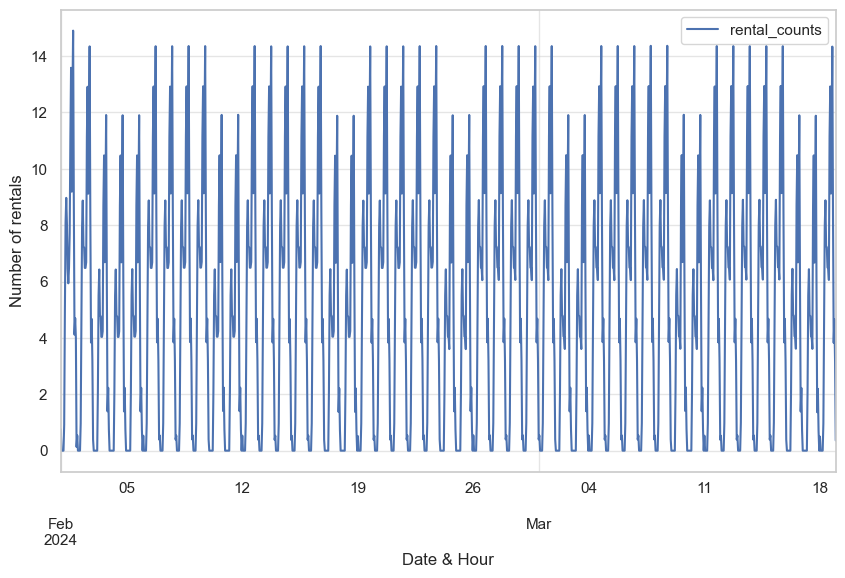

In [229]:
plt.figure(figsize=(10, 6))  # Adjust width as needed
forecast.plot(figsize=(10, 6))
plt.xlabel('Date & Hour')
plt.ylabel('Number of rentals')
plt.grid(alpha=0.5)
plt.show()

## Retrieve forecast with user query

In [230]:
def retrieve_forecast(search_datetime):
    return_forecast = weather_noscale[weather_noscale.index.astype(str).str.contains(search_datetime)]
    return return_forecast


In [231]:
search_datetime = input("Retrieve forecast for desired date and hour [yyyy-mm-dd hh]\n"
                        "Search for a full year, a full month, or a full day by leaving out the succeeding values.\n"
                        "e.g. 2024-01-02 full a full day, or 2024-01 for a full month.\n").strip()

Retrieve forecast for desired date and hour [yyyy-mm-dd hh]
Search for a full year, a full month, or a full day by leaving out the succeeding values.
e.g. 2024-01-02 full a full day, or 2024-01 for a full month.
2024-02-29


In [232]:
retrieve_forecast = retrieve_forecast(search_datetime)
retrieve_forecast.head(25)

,temperature_C,rel_humidity_perc,feels_like_temp_C,rain_mm,wind_speed_kmh,is_day,is_business_day,rental_forecast
hour,,,,,,,,
2024-02-29 00:00:00,27.3,14.0,21.5,0.0,22.3,1,1,1.0
2024-02-29 01:00:00,24.3,25.0,20.2,0.0,16.7,0,1,0.0
2024-02-29 02:00:00,23.0,29.0,19.9,0.0,11.2,0,1,0.0
2024-02-29 03:00:00,21.6,20.0,17.0,0.0,15.3,0,1,0.0
2024-02-29 04:00:00,20.0,24.0,15.9,0.0,12.2,0,1,0.0
2024-02-29 05:00:00,18.7,27.0,14.7,0.0,12.0,0,1,1.0
2024-02-29 06:00:00,17.5,27.0,12.6,0.0,17.6,0,1,5.0
2024-02-29 07:00:00,15.6,55.0,12.1,0.0,18.2,0,1,8.0
2024-02-29 08:00:00,13.8,80.0,11.7,0.0,15.3,0,1,9.0


## Compare with actual Ecobici data from February 2024

In [233]:
station_6_feb = pd.read_csv('DATA/station_6_february.csv')

In [234]:
station_6_feb['pickup_datetime'] = pd.to_datetime(station_6_feb['pickup_datetime'])
station_6_feb['hourly_aggregated'] = pd.to_datetime(station_6_feb['hourly_aggregated'])

In [235]:
full_index = pd.date_range(start='2024-01-31 23:00:00', end='2024-02-29 23:00:00', freq='H')

station_6_feb_agg = station_6_feb.groupby('hourly_aggregated',as_index=False).agg(
    {'bike_id': 'count',
     'is_business_day': 'first'
    }
)
# reformat df columns and duration values, reset index
station_6_feb_agg.rename(columns={'hourly_aggregated':'hour','bike_id':'rental_counts','duration':'avg_rental_duration'},inplace=True)
station_6_feb_agg.set_index('hour', drop=False, inplace=True)
station_6_feb_agg = station_6_feb_agg.reindex(full_index)
station_6_feb_agg.hour = station_6_feb_agg.index
station_6_feb_agg.fillna(0, inplace=True)


station_6_feb_agg.drop('hour', axis=1,inplace=True)

# stations_hourly_dict[key] = station_aggregated

# print(f"Aggregated dataframe for station {key} was created.")

In [236]:
station_6_feb_agg.drop(station_6_feb_agg.index[0], inplace=True)

In [237]:
station_6_feb_agg

,rental_counts,is_business_day
2024-02-01 00:00:00,2.0,1.0
2024-02-01 01:00:00,0.0,0.0
2024-02-01 02:00:00,0.0,0.0
2024-02-01 03:00:00,0.0,0.0
2024-02-01 04:00:00,0.0,0.0
...,...,...
2024-02-29 19:00:00,11.0,1.0
2024-02-29 20:00:00,4.0,1.0
2024-02-29 21:00:00,3.0,1.0
2024-02-29 22:00:00,3.0,1.0


In [246]:
weather_noscale

,temperature_C,rel_humidity_perc,feels_like_temp_C,rain_mm,wind_speed_kmh,is_day,is_business_day,rental_forecast
hour,,,,,,,,
2024-02-01 00:00:00,21.3,21.0,18.4,0.0,3.3,1,1,1.0
2024-02-01 01:00:00,19.5,26.0,15.4,0.0,13.0,0,1,0.0
2024-02-01 02:00:00,18.6,29.0,16.2,0.0,2.5,0,1,0.0
2024-02-01 03:00:00,17.0,40.0,13.6,0.0,12.3,0,1,0.0
2024-02-01 04:00:00,14.8,53.0,12.9,0.0,5.0,0,1,0.0
...,...,...,...,...,...,...,...,...
2024-03-18 19:00:00,18.8,31.0,19.6,0.0,3.3,1,1,8.0
2024-03-18 20:00:00,20.3,26.0,20.5,0.0,4.2,1,1,4.0
2024-03-18 21:00:00,20.4,27.0,19.2,0.0,6.6,1,1,5.0


In [254]:
forecast_residuals_full = station_6_feb_agg.merge(weather_noscale['rental_forecast'], left_index=True, right_index=True, how='inner')
# forecast_residuals_full.drop('is_business_day',inplace=True)
forecast_residuals_full['residuals'] = forecast_residuals_full['rental_counts'] - forecast_residuals_full['rental_forecast']
forecast_residuals_full
mae_test = round(mae(forecast_residuals_full['rental_counts'],forecast_residuals_full.rental_forecast),2)
print(f'mean absolute error of full forecast: {mae_test}')

,rental_counts,is_business_day,rental_forecast,residuals
2024-02-01 00:00:00,2.0,1.0,1.0,1.0
2024-02-01 01:00:00,0.0,0.0,0.0,0.0
2024-02-01 02:00:00,0.0,0.0,0.0,0.0
2024-02-01 03:00:00,0.0,0.0,0.0,0.0
2024-02-01 04:00:00,0.0,0.0,0.0,0.0
...,...,...,...,...
2024-02-29 19:00:00,11.0,1.0,8.0,3.0
2024-02-29 20:00:00,4.0,1.0,4.0,0.0
2024-02-29 21:00:00,3.0,1.0,5.0,-2.0
2024-02-29 22:00:00,3.0,1.0,3.0,0.0


mean absolute error of full forecast: 2.64


In [238]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

forecast_residuals = station_6_feb_agg.merge(retrieve_forecast, left_index=True, right_index=True, how='inner')
forecast_residuals = forecast_residuals[['rental_counts','rental_forecast']]
forecast_residuals['residuals'] = forecast_residuals['rental_counts']-forecast_residuals['rental_forecast']
forecast_residuals

,rental_counts,rental_forecast,residuals
2024-02-29 00:00:00,0.0,1.0,-1.0
2024-02-29 01:00:00,0.0,0.0,0.0
2024-02-29 02:00:00,0.0,0.0,0.0
2024-02-29 03:00:00,0.0,0.0,0.0
2024-02-29 04:00:00,0.0,0.0,0.0
2024-02-29 05:00:00,2.0,1.0,1.0
2024-02-29 06:00:00,9.0,5.0,4.0
2024-02-29 07:00:00,14.0,8.0,6.0
2024-02-29 08:00:00,15.0,9.0,6.0
2024-02-29 09:00:00,10.0,7.0,3.0


In [244]:
# mae_test = round(mae(station_6_feb_agg['rental_counts'],retrieve_forecast.rental_forecast),2) # mean absolute error
mae_test = round(mae(station_6_feb_agg.loc[
    (station_6_feb_agg.index >= retrieve_forecast.index[0]) & 
    (station_6_feb_agg.index <= retrieve_forecast.index[-1]),
    'rental_counts'],
    retrieve_forecast.rental_forecast), 
    2)
print(f'mean absolute error of forecast demo: {mae_test}')


mean absolute error of forecast demo: 3.54


In [114]:
forecast_residuals.tail(50)

,rental_counts,forecast,residuals
2024-02-27 22:00:00,4.0,3.0,1.0
2024-02-27 23:00:00,2.0,0.0,2.0
2024-02-28 00:00:00,1.0,1.0,0.0
2024-02-28 01:00:00,0.0,0.0,0.0
2024-02-28 02:00:00,0.0,0.0,0.0
2024-02-28 03:00:00,0.0,0.0,0.0
2024-02-28 04:00:00,0.0,0.0,0.0
2024-02-28 05:00:00,2.0,1.0,1.0
2024-02-28 06:00:00,4.0,5.0,-1.0
2024-02-28 07:00:00,16.0,8.0,8.0
